In [6]:
import pandas as pd

df = pd.read_parquet('yelp_academic_dataset_business_cleaned.parquet')

df.to_csv('yelp_academic_dataset_business_cleaned.csv', index=False)

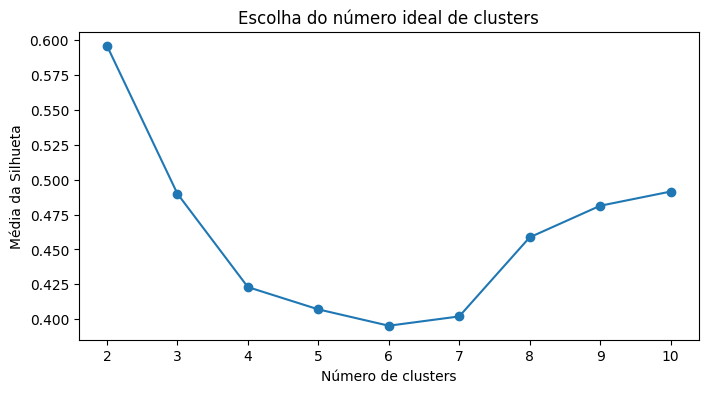

Melhor número de clusters: 2
Média da silhueta para 2 clusters: 0.59613853793222


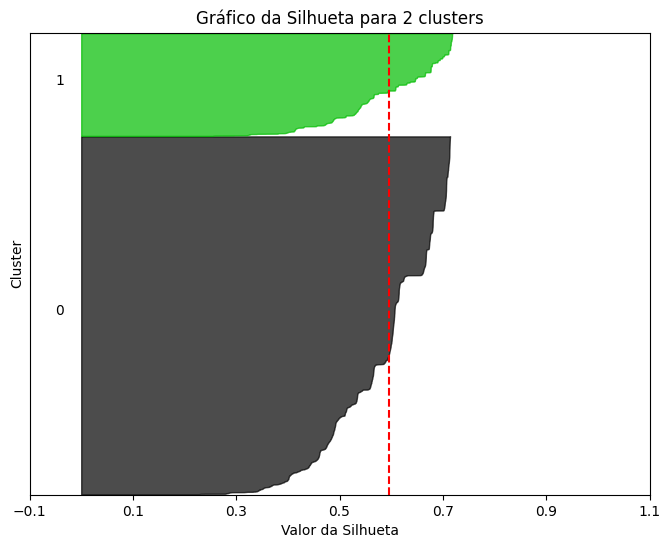

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA  

# Carregar os dados
df = pd.read_csv('yelp_academic_dataset_business_cleaned.csv')

# Reduzir para 10.000 amostras para melhor desempenho
sampled_df = df.sample(n=10000, random_state=2)

# Selecionar colunas relevantes
columns = ['stars', 'review_count', 'latitude', 'longitude', 'categories']
sampled_df = sampled_df[columns]

# Separar variáveis numéricas e categóricas
numeric_features = ['stars', 'review_count', 'latitude', 'longitude']
categorical_features = ['categories']

# Normalizar numéricos e transformar categóricos em One-Hot Encoding
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Aplicar transformação
processed_data = preprocessor.fit_transform(sampled_df)
processed_data_dense = processed_data.toarray()

# Redução de dimensionalidade com PCA (2 componentes)
pca = PCA(n_components=2, random_state=2)
processed_data_pca = pca.fit_transform(processed_data_dense)

# MÉTODO DA SILHUETA PARA ESCOLHER O MELHOR K
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(processed_data_pca)
    score = silhouette_score(processed_data_pca, labels)
    silhouette_scores.append(score)

# 🔹 Plotar o gráfico do coeficiente de silhueta
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Média da Silhueta')
plt.title('Escolha do número ideal de clusters')
plt.show()

#  ESCOLHER O MELHOR K (pode ser o de maior pontuação)
best_k = k_values[np.argmax(silhouette_scores)]
print(f'Melhor número de clusters: {best_k}')

#  ANÁLISE DE SILHUETA PARA O MELHOR K
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, processed_data_pca.shape[0] + (best_k + 1) * 10])

# 🔹 Treinar K-Means com o melhor número de clusters
kmeans = KMeans(n_clusters=best_k, random_state=2)
cluster_labels = kmeans.fit_predict(processed_data_pca)

silhouette_avg = silhouette_score(processed_data_pca, cluster_labels)
print(f'Média da silhueta para {best_k} clusters: {silhouette_avg}')

sample_silhouette_values = silhouette_samples(processed_data_pca, cluster_labels)

y_lower = 10
for i in range(best_k):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / best_k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_title(f'Gráfico da Silhueta para {best_k} clusters')
ax1.set_xlabel('Valor da Silhueta')
ax1.set_ylabel('Cluster')

ax1.axvline(x=silhouette_avg, color='red', linestyle='--')

ax1.set_yticks([])
ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))
plt.show()

# clusterização 
kmeans_model = KMeans(n_clusters=6, random_state=2)

# Ajustar o modelo e obter as previsões
kmeans_result = kmeans_model.fit_predict(processed_data)

# Reduzir a dimensionalidade para 2D com PCA para o gráfico de dispersão
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(processed_data)

# Plotar os clusters
plt.figure(figsize=(8, 6))

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_result, cmap='viridis', s=50, alpha=0.5)

# Adicionar títulos e rótulos aos eixos
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering (Dados Numéricos + Categóricos)')

# Exibir o gráfico
plt.show()
